# Phishing Website Classification Analysis

This is a machine learning analysis of the 'Phishing Websites Data Set' hosted in the UCI Machine Learning Repository.

Feature descriptions for this data set are listed here: https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Phishing%20Websites%20Features.docx

This analysis includes: 
- Data ingestion from the UCI repository 
- Data wrangling and storage
- Data exploration and visualization 
- Data wrangling with Scikit-Learn transformers 
- Operationalization of the fitted estimator

# Import python packages required for analysis.

In [1]:
%matplotlib inline

import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.base import Bunch

import json
import time
import pickle
import csv

# Ingest dataset from the UCI repository. 

This section uses Requests to retreive the .arff dataset file from the UCI repo and writes the file to disk.

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Training%20Dataset.arff"
    
def fetch_data(fname='Training_Dataset.arff'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    return outpath

data = fetch_data()
print (data)

/home/merlinuser/Desktop/Make-up Assignment/Training_Dataset.arff


The .arff file needs to be converted to to a .csv file, so the data can be read-in to a pandas dataframe for initial analysis. I did this using the getCSVFromArff() function. Though modified slightly for my purposes here, the code for thsi function was provided in this blog: http://biggyani.blogspot.com/2014/08/converting-back-and-forth-between-weka.html.

In [3]:
def getCSVFromArff(fileNameArff, fileNameSmoted):

    with open(fileNameArff, 'r') as fin:
        data = fin.read().splitlines(True)
    
    i = 0
    cols = []
    for line in data:
        if ('@data' in line):
            i+= 1
            break
        else:
            #print line
            i+= 1
            if (line.startswith('@attribute')):
                if('{' in line):
                    cols.append(line[11:line.index('{')-1])
                else:
                    cols.append(line[11:line.index('numeric')-1])
    
    headers = ",".join(cols)
    
    with open(fileNameSmoted + '.csv', 'w') as fout:
        fout.write(headers)
        fout.write('\n')
        fout.writelines(data[i:])

getCSVFromArff(data, 'Training_Dataset')

# Data Wrangling and Storage 

Next, I read-in the data with pandas, and used the head() function to look at dataframe and ensure it doesn't look wonky. I also wrote the this data back to disk as a .txt file with the headers and index stripped out. This will be used to later to read the data in to be passed to the machine-learning pipeline.

In [2]:
df = pd.read_csv('Training_Dataset.csv')
df.columns = ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']
df.to_csv(path_or_buf='Training_Dataset1.txt',delimiter=',',header=False, index=False)
df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


The data in the pandas dataframe looks good. I also doubled checked the file saved to disk to ensure that data was stored as expected.

In [3]:
with open ('Training_Dataset1.txt') as f:
    for idx, line in enumerate(f):
        if idx> 10:
            break
        else:
            print (line)

-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1

1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1

1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1

1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1

1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1

-1,0,-1,1,-1,-1,1,1,-1,1,1,-1,1,0,0,-1,-1,-1,0,1,1,1,1,1,1,1,-1,1,-1,-1,1

1,0,-1,1,1,-1,-1,-1,1,1,1,1,-1,-1,0,-1,-1,-1,0,1,1,1,1,1,-1,-1,-1,1,0,-1,-1

1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,0,1,-1

1,0,-1,1,1,-1,1,1,-1,1,1,-1,1,0,1,-1,1,1,0,1,1,1,1,1,-1,1,1,1,0,1,1

1,1,-1,1,1,-1,-1,1,-1,1,1,1,1,0,1,-1,1,1,0,1,1,1,1,1,-1,0,-1,1,0,1,-1

1,1,1,1,1,-1,0,1,1,1,1,1,-1,0,0,-1,-1,-1,0,1,1,1,1,-1,1,1,1,1,-1,-1,1



The data looks okay. As noted in the documentation, all the features are categorical, and as indicated by the output above, these categorical features are already numerically encoded. Alignment of textual descriptions to numerical encoding were not explicitly provided in the .arff file itself. 

Next I looped through the data set and replaced encoded categorical values with string values from documentation (-1=phishing,1=legitimate), (-1=legitimate, 0=suspicious, 1= phishing). I labeled this df2, and kept df as the numerically encoded data. 

In [4]:
df_lists = []
for i in df.columns:
    x = df["%s" % i].tolist()
    if 0 not in x:
        for n,i in enumerate(x):
            if i==-1:
                x[n]='phishing'
            elif i==1:
                x[n]='legitimate'
    elif 0 in x:
        for n,i in enumerate(x):
            if i==-1:
                x[n]='legitimate'
            elif i==1:
                x[n]='suspicious'
            else:
                x[n]='phishing'
    df_lists.append(x)
    
headers = ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']
df2 = pd.DataFrame(df_lists)
df2 = df2.transpose()
df2.columns = headers
df2.to_csv(path_or_buf='Training_Dataset2.txt',delimiter=',',header=False, index=False)
df2.head()           

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,phishing,suspicious,legitimate,legitimate,phishing,phishing,legitimate,legitimate,phishing,legitimate,...,legitimate,legitimate,phishing,phishing,legitimate,phishing,legitimate,suspicious,phishing,phishing
1,legitimate,suspicious,legitimate,legitimate,legitimate,phishing,phishing,suspicious,phishing,legitimate,...,legitimate,legitimate,phishing,phishing,phishing,phishing,legitimate,suspicious,legitimate,phishing
2,legitimate,phishing,legitimate,legitimate,legitimate,phishing,legitimate,legitimate,phishing,legitimate,...,legitimate,legitimate,legitimate,phishing,suspicious,phishing,legitimate,phishing,phishing,phishing
3,legitimate,phishing,legitimate,legitimate,legitimate,phishing,legitimate,legitimate,legitimate,legitimate,...,legitimate,legitimate,phishing,phishing,suspicious,phishing,legitimate,legitimate,legitimate,phishing
4,legitimate,phishing,phishing,legitimate,legitimate,phishing,suspicious,suspicious,phishing,legitimate,...,phishing,legitimate,phishing,phishing,phishing,phishing,legitimate,suspicious,legitimate,legitimate


I then re-encoded the numeric data to remove the negative values using the same script to update the encoding as follows:

Legitimate = 0, Phishing = 2

Legitimate = 0, Suspicious = 1, Phishing = 2

In hindsight this step was not really necessary.

In [5]:
df_lists = []
for i in df2.columns:
    x = df2["%s" % i].tolist()
    if 'suspicious' not in x:
        for n,i in enumerate(x):
            if i=='legitimate':
                x[n]= 0
            elif i=='phishing':
                x[n]= 2
    elif 'suspicious' in x:
        for n,i in enumerate(x):
            if i=='legitimate':
                x[n]= 0
            elif i== 'suspicious':
                x[n]= 1
            else:
                x[n]=2
    df_lists.append(x)

headers = ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']
df = pd.DataFrame(df_lists)
df = df.transpose()
df.columns = headers
df.to_csv(path_or_buf='Training_Dataset1.txt',delimiter=',',header=False, index=False)
df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,2,1,0,0,2,2,0,0,2,0,...,0,0,2,2,0,2,0,1,2,2
1,0,1,0,0,0,2,2,1,2,0,...,0,0,2,2,2,2,0,1,0,2
2,0,2,0,0,0,2,0,0,2,0,...,0,0,0,2,1,2,0,2,2,2
3,0,2,0,0,0,2,0,0,0,0,...,0,0,2,2,1,2,0,0,0,2
4,0,2,2,0,0,2,1,1,2,0,...,2,0,2,2,2,2,0,1,0,0


Since I updated the .txt file, I doubled checked this data again.

In [6]:
with open ('Training_Dataset1.txt') as f:
    for idx, line in enumerate(f):
        if idx> 10:
            break
        else:
            print (line)

2,1,0,0,2,2,0,0,2,0,0,2,0,0,1,0,2,2,2,0,0,0,0,2,2,0,2,0,1,2,2

0,1,0,0,0,2,2,1,2,0,0,2,0,2,0,0,0,0,2,0,0,0,0,2,2,2,2,0,1,0,2

0,2,0,0,0,2,0,0,2,0,0,2,0,2,0,0,2,2,2,0,0,0,0,0,2,1,2,0,2,2,2

0,2,0,0,0,2,0,0,0,0,0,2,2,2,2,0,0,0,2,0,0,0,0,2,2,1,2,0,0,0,2

0,2,2,0,0,2,1,1,2,0,0,0,0,2,2,0,0,0,2,2,0,2,0,2,2,2,2,0,1,0,0

2,2,2,0,2,2,1,1,2,0,0,2,0,2,2,0,2,2,2,0,0,0,0,0,0,1,2,0,0,2,0

0,2,2,0,0,2,0,0,0,0,0,0,2,0,2,0,2,2,2,0,0,0,0,0,2,0,2,0,2,2,2

0,2,0,0,0,2,0,0,0,0,0,2,2,2,0,0,0,0,2,0,0,0,0,2,2,2,2,0,2,0,2

0,2,2,0,0,2,1,1,2,0,0,2,0,2,1,0,0,0,2,0,0,0,0,0,2,1,0,0,2,0,0

0,1,2,0,0,2,0,1,2,0,0,0,0,2,1,0,0,0,2,0,0,0,0,0,2,2,2,0,2,0,2

0,1,0,0,0,2,2,1,0,0,0,0,2,2,2,0,2,2,2,0,0,0,0,2,0,1,0,0,0,2,0



# Data Exploration and Visualization

Next I determined the shape of the data.

In [7]:
print ("{} instances with {} features\n".format(*df2.shape))

11055 instances with 31 features



The number of instances in this dataframe is higher than number listed in documentation for the dataset, which is disconcerning. This number is consistent with the rows in the retreived .arff file though, so the error does not seem to be in my process. 

Next I displayed a histogram of the features in the dataframe, to get an idea of the shape of each feature. Alternatively, if the data was not all categorical I could have generated a scatter plots. With this data though, scatter plots are not useful. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52d19d9550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f52cea09f28>]], dtype=object)

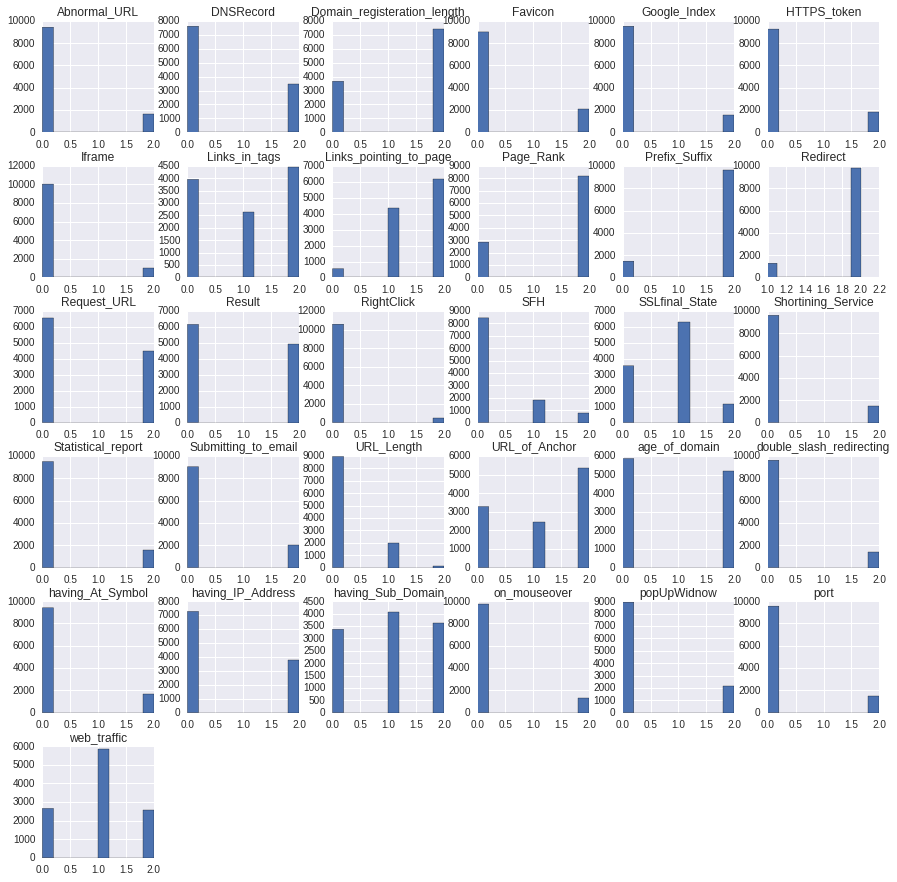

In [8]:
df.hist(figsize=(15,15))

Next I viewed the 'results' data as a factor plot against each of the features so see if there was any unexpected relationships that were immediately apparent.

/home/merlinuser/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


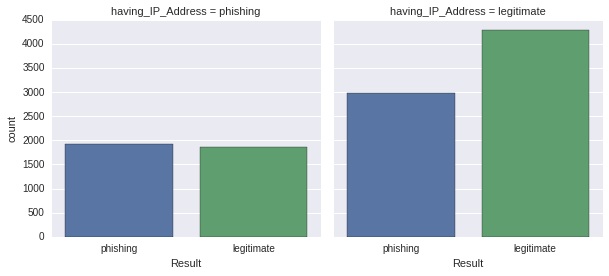

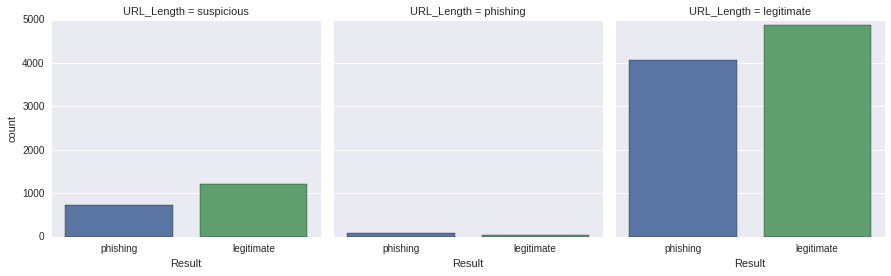

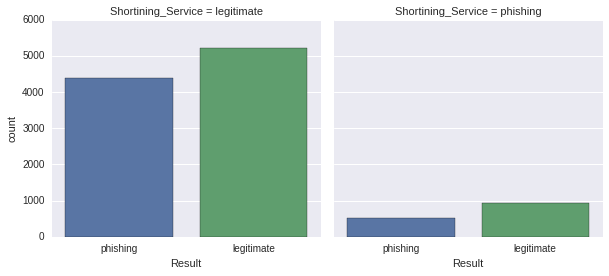

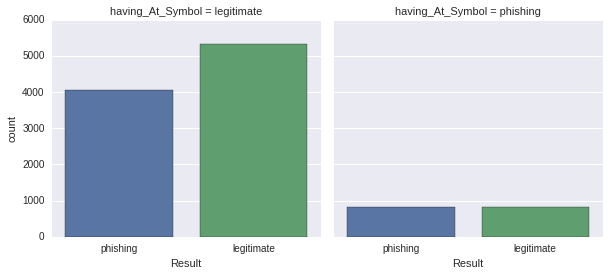

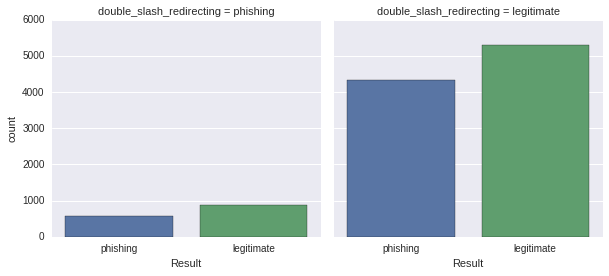

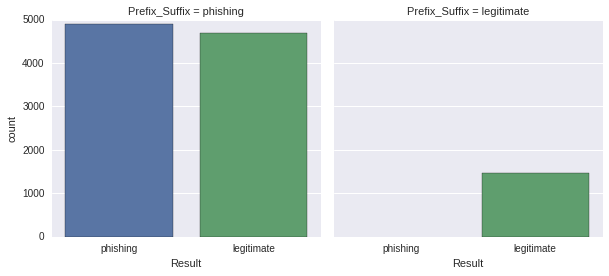

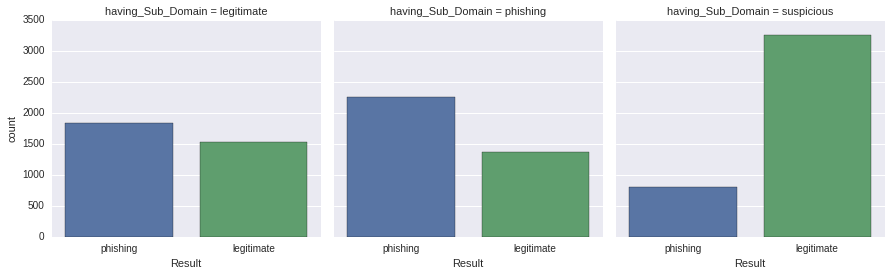

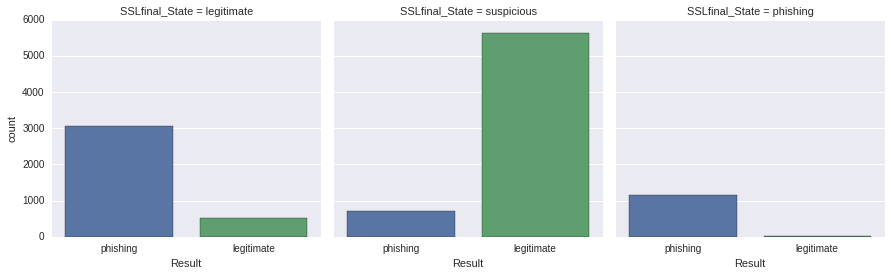

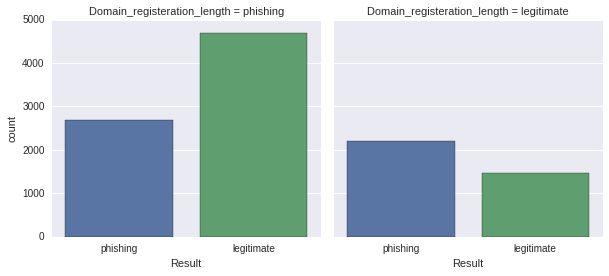

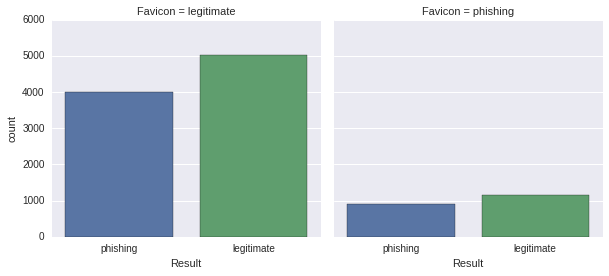

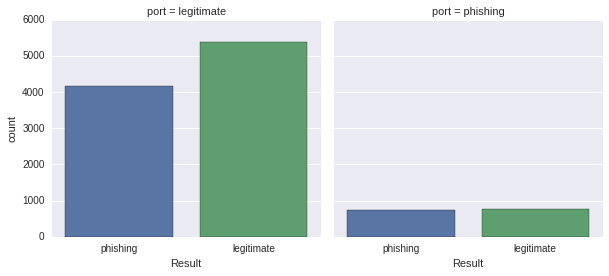

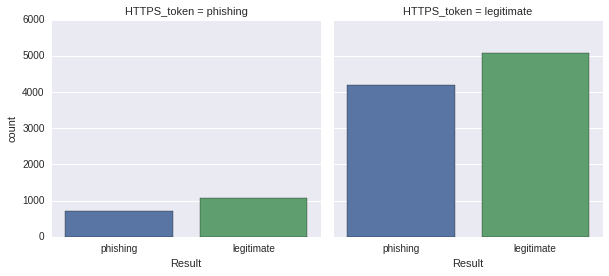

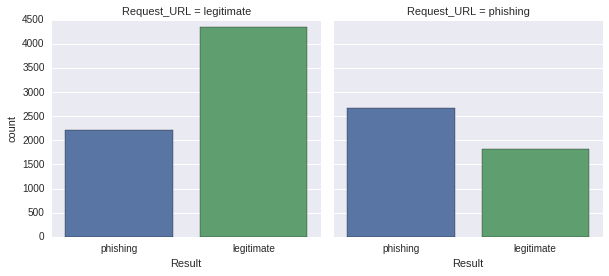

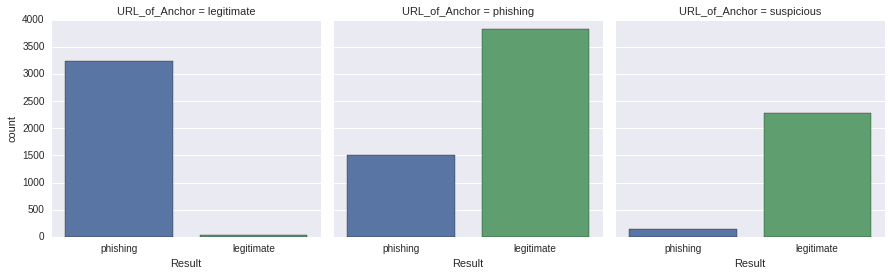

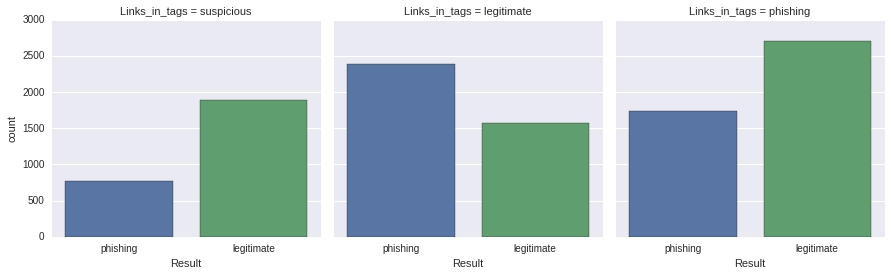

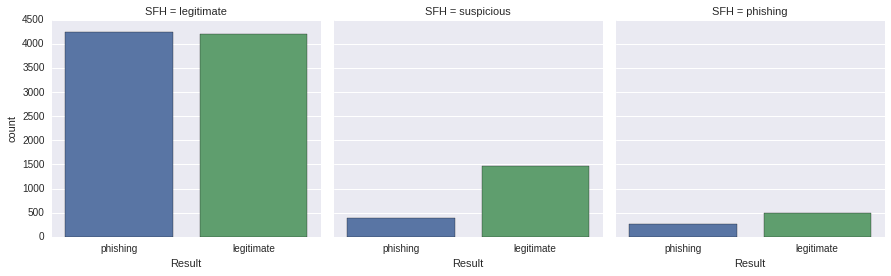

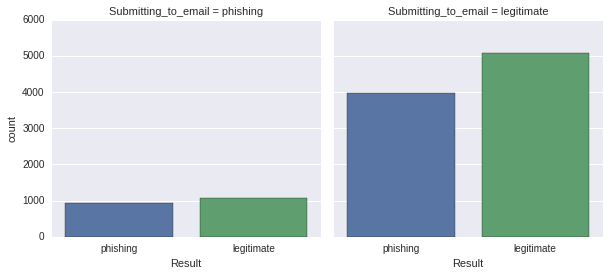

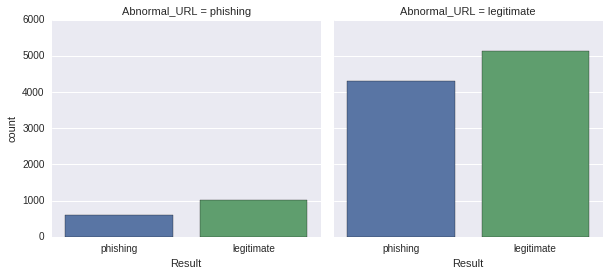

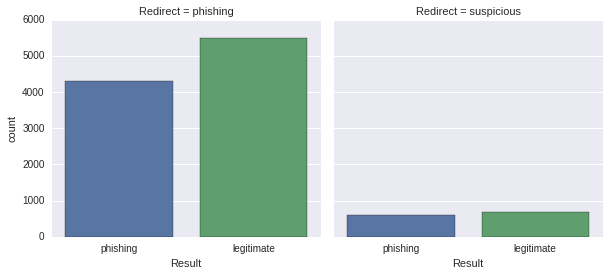

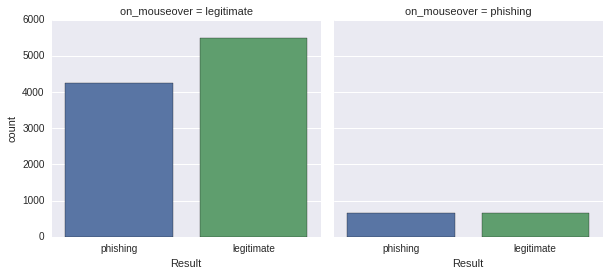

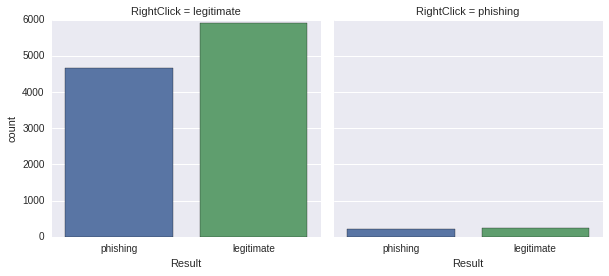

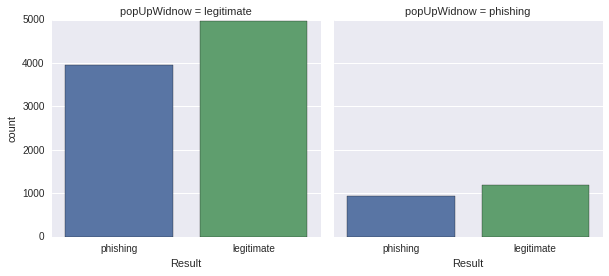

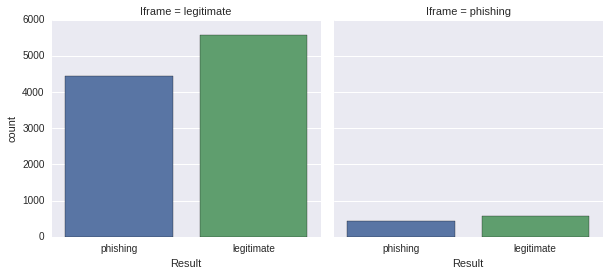

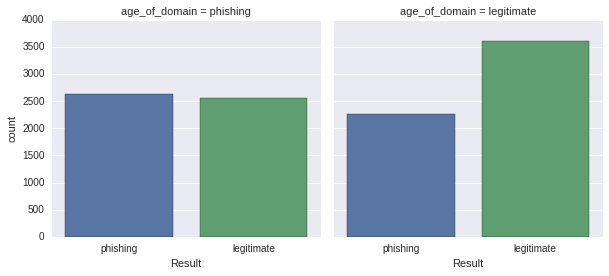

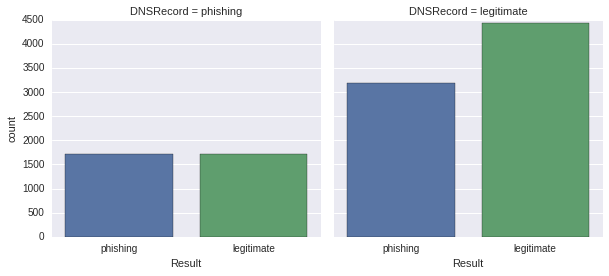

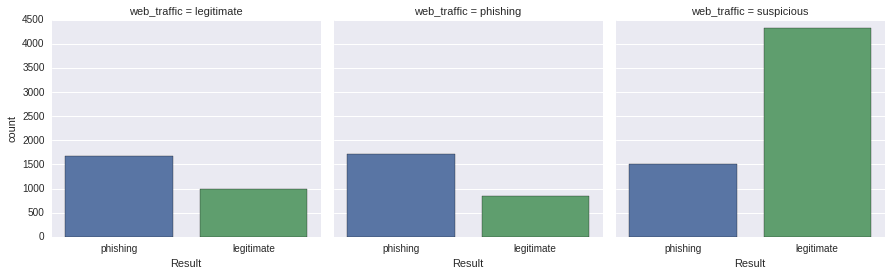

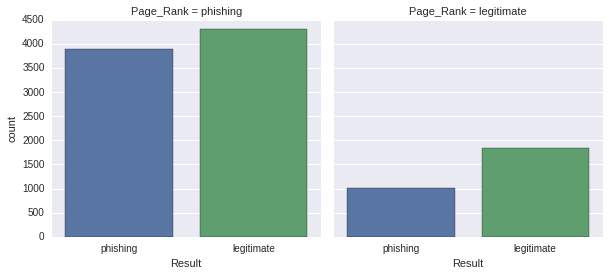

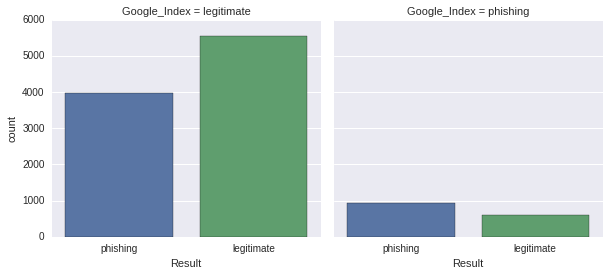

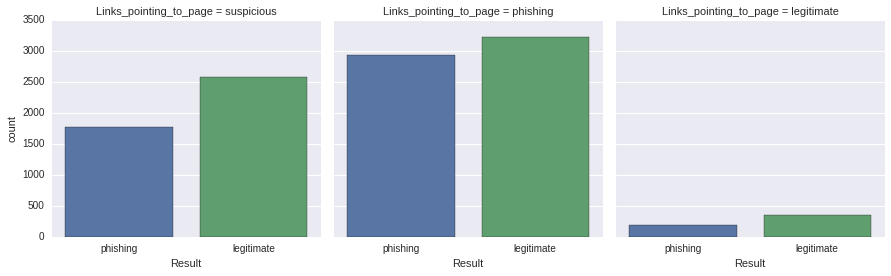

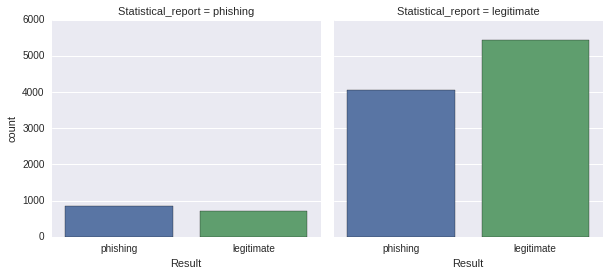

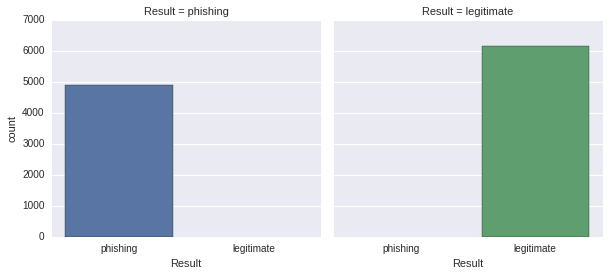

In [9]:
for i in df2[:len(df2)-1]:
    g = sns.factorplot("Result", col=i, data=df2,
                    kind="count", size=4, aspect=1, col_wrap=7)


I originally generated a parallel coordinates chart. Since the dependent variable (results) is bianary this graph is not useful. There were probably too many features for this to reveal much anyway. I've hashed out the original code.

In [10]:
#from pandas.tools.plotting import parallel_coordinates
#plt.figure(figsize=(20,20))
#parallel_coordinates(df, 'Result')
#plt.show()

Next I generate Radviz chart, to see if any patterns were visually apparent with this approach. This was better, though probably still too many features to gain much insight.

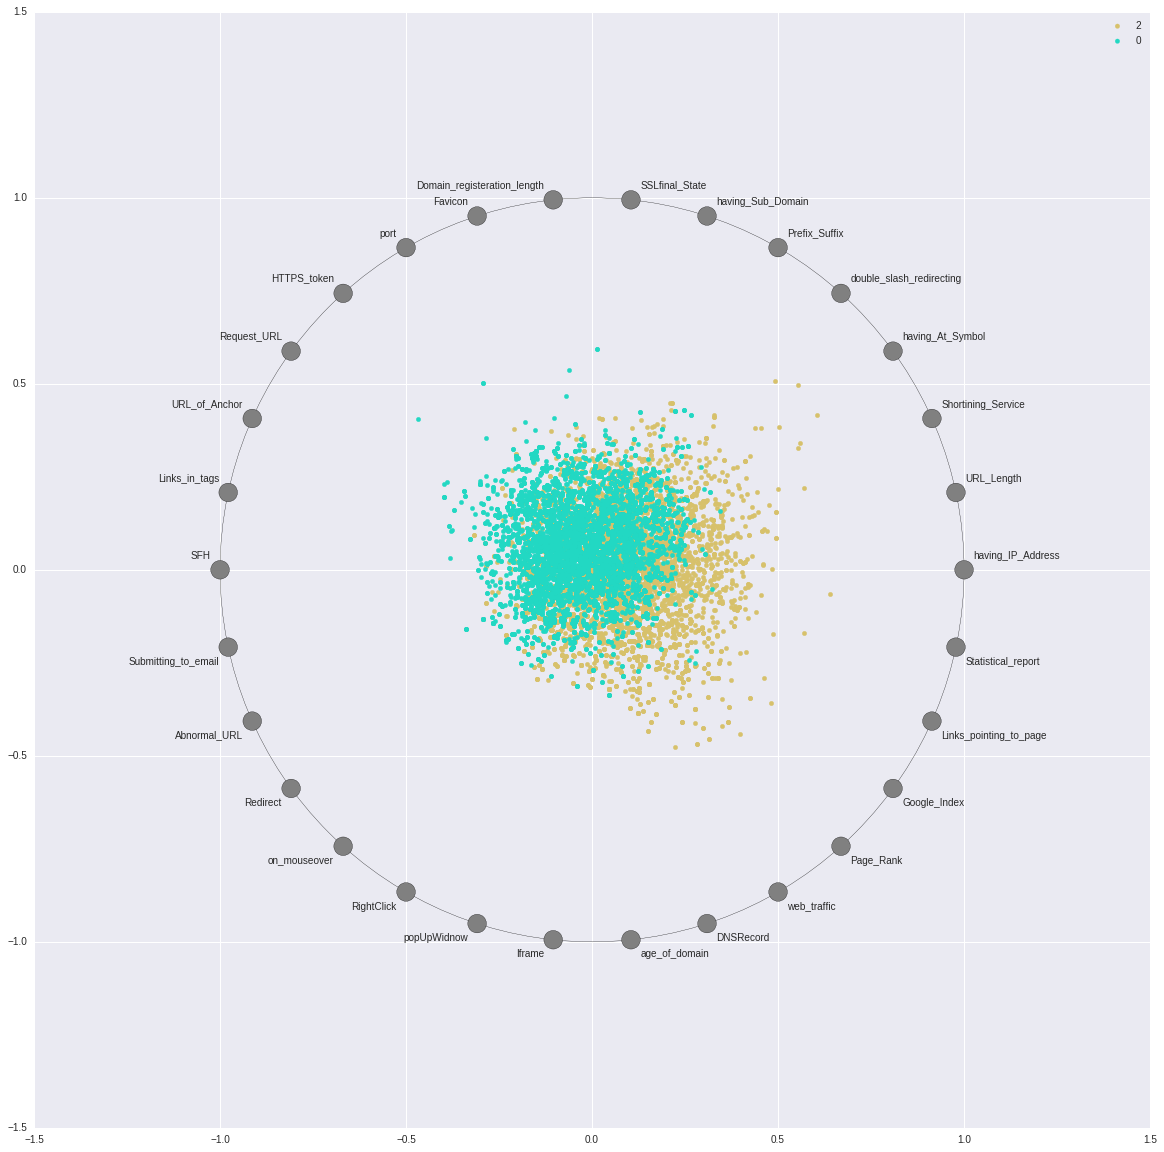

In [11]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(20,20))
radviz(df, 'Result')
plt.show()

# Conduct Feature Selection Analysis

Since there is an abundance of features in the dataset, I used several regularization methods to identify the most significant among them. I then conducted some additional visualization. 

Depending on model selection, this prioritized subset of features could be used to help improve model performance. Ultimately this was not necessary given model performance with all features included, as will be illustrated further in this walk though. 

The prioritized subset of features could also be advantageous from an operational perspective. If model performance can be maintained with the limited feature set, this could potentially be used to reduce data ingestion and storage requirements when conducting further analysis using the model.

First I seperated the features from what will eventually be by target value to predict.

In [12]:
features = df[['having_IP_Address','URL_Length','Shortining_Service','having_At_Symbol','double_slash_redirecting','Prefix_Suffix','having_Sub_Domain','SSLfinal_State','Domain_registeration_length','Favicon','port','HTTPS_token','Request_URL','URL_of_Anchor','Links_in_tags','SFH','Submitting_to_email','Abnormal_URL','Redirect','on_mouseover','RightClick','popUpWidnow','Iframe','age_of_domain','DNSRecord','web_traffic','Page_Rank','Google_Index','Links_pointing_to_page','Statistical_report']]
labels = df['Result']

In [13]:
list (features)

['having_IP_Address',
 'URL_Length',
 'Shortining_Service',
 'having_At_Symbol',
 'double_slash_redirecting',
 'Prefix_Suffix',
 'having_Sub_Domain',
 'SSLfinal_State',
 'Domain_registeration_length',
 'Favicon',
 'port',
 'HTTPS_token',
 'Request_URL',
 'URL_of_Anchor',
 'Links_in_tags',
 'SFH',
 'Submitting_to_email',
 'Abnormal_URL',
 'Redirect',
 'on_mouseover',
 'RightClick',
 'popUpWidnow',
 'Iframe',
 'age_of_domain',
 'DNSRecord',
 'web_traffic',
 'Page_Rank',
 'Google_Index',
 'Links_pointing_to_page',
 'Statistical_report']

### Regularization

The three methods I used were Lasso (L1 Regularization), Ridge Regression (L2 Regularization), and ElasticNet. First I displayed the features and their coeficients. Then used SciKit-Learn Transformer methods to use thess three methods again, diplaying just significant features. 

Lasso (L1 Regularization)

In [14]:
model = Lasso()
model.fit(features, labels)
output = list(zip(features, model.coef_.tolist()))
for i in output:
    print(i)

('having_IP_Address', 0.0)
('URL_Length', -0.0)
('Shortining_Service', -0.0)
('having_At_Symbol', 0.0)
('double_slash_redirecting', -0.0)
('Prefix_Suffix', 0.0)
('having_Sub_Domain', 0.0)
('SSLfinal_State', -0.0)
('Domain_registeration_length', -0.0)
('Favicon', -0.0)
('port', 0.0)
('HTTPS_token', -0.0)
('Request_URL', 0.0)
('URL_of_Anchor', -0.0)
('Links_in_tags', -0.0)
('SFH', -0.0)
('Submitting_to_email', 0.0)
('Abnormal_URL', -0.0)
('Redirect', -0.0)
('on_mouseover', 0.0)
('RightClick', 0.0)
('popUpWidnow', 0.0)
('Iframe', -0.0)
('age_of_domain', 0.0)
('DNSRecord', 0.0)
('web_traffic', 0.0)
('Page_Rank', 0.0)
('Google_Index', 0.0)
('Links_pointing_to_page', 0.0)
('Statistical_report', 0.0)


Ridge Regression (L2 Regularization)

In [15]:
model = Ridge()
model.fit(features, labels)
output = list(zip(features, model.coef_.tolist()))
for i in output:
    print(i)

('having_IP_Address', 0.13884181555402794)
('URL_Length', 0.15737383528433904)
('Shortining_Service', -0.19582277544430932)
('having_At_Symbol', 0.05908193301041499)
('double_slash_redirecting', 0.010103118286286046)
('Prefix_Suffix', 0.35945343674480357)
('having_Sub_Domain', 0.058787431626748834)
('SSLfinal_State', -0.238824838239722)
('Domain_registeration_length', -0.05966497534301032)
('Favicon', -0.09456482961248242)
('port', 0.027026137631373237)
('HTTPS_token', 0.008799260084676002)
('Request_URL', 0.07611087066328649)
('URL_of_Anchor', -0.5276824200186273)
('Links_in_tags', -0.1182500624348249)
('SFH', -0.19414079052819883)
('Submitting_to_email', 0.04580572468343289)
('Abnormal_URL', -0.12714527028674624)
('Redirect', -0.1844871900623861)
('on_mouseover', 0.07348223547364831)
('RightClick', 0.04695355627794568)
('popUpWidnow', -0.037727327517008295)
('Iframe', -0.12410033581600925)
('age_of_domain', 0.04823752433063014)
('DNSRecord', 0.11900342663391208)
('web_traffic', 0.107

ElasticNet

In [16]:
model = ElasticNet(l1_ratio=0.10)
model.fit(features, labels)
output = list(zip(features, model.coef_.tolist()))
for i in output: 
    print(i)

('having_IP_Address', 0.0)
('URL_Length', -0.0)
('Shortining_Service', -0.0)
('having_At_Symbol', 0.0)
('double_slash_redirecting', -0.0)
('Prefix_Suffix', 0.08462043469559424)
('having_Sub_Domain', 0.0)
('SSLfinal_State', -0.028824239120753634)
('Domain_registeration_length', -0.030526096200019406)
('Favicon', -0.0)
('port', 0.0)
('HTTPS_token', -0.0)
('Request_URL', 0.04805812013593464)
('URL_of_Anchor', -0.22126921181736436)
('Links_in_tags', -0.02566985500918772)
('SFH', -0.0)
('Submitting_to_email', 0.0)
('Abnormal_URL', -0.0)
('Redirect', -0.0)
('on_mouseover', 0.0)
('RightClick', 0.0)
('popUpWidnow', -0.0)
('Iframe', -0.0)
('age_of_domain', 0.0)
('DNSRecord', 0.0)
('web_traffic', 0.0)
('Page_Rank', 0.0)
('Google_Index', 0.0)
('Links_pointing_to_page', 0.0)
('Statistical_report', 0.0)


### Transformer Methods

SelectFromModel()

In [17]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
output_lasso = (list(features[sfm.get_support(indices=True)]))
for i in output_lasso:
    print(i)

In [18]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
output_ridge = (list(features[sfm.get_support(indices=True)]))
for i in output_ridge:
    print(i)

having_IP_Address
URL_Length
Shortining_Service
Prefix_Suffix
SSLfinal_State
URL_of_Anchor
SFH
Abnormal_URL
Redirect
Iframe


In [19]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
output_elasticnet = (list(features[sfm.get_support(indices=True)]))
for i in output_elasticnet:
    print(i)

having_IP_Address
URL_Length
Shortining_Service
having_At_Symbol
double_slash_redirecting
Prefix_Suffix
having_Sub_Domain
SSLfinal_State
Domain_registeration_length
Favicon
port
HTTPS_token
Request_URL
URL_of_Anchor
Links_in_tags
SFH
Submitting_to_email
Abnormal_URL
Redirect
on_mouseover
RightClick
popUpWidnow
Iframe
age_of_domain
DNSRecord
web_traffic
Page_Rank
Google_Index
Links_pointing_to_page
Statistical_report


Next I repeated the visualization with fewer features. L2 Regularization seemed to provide the best result, so I limited the visualization to just these features. The result was still difficult to interpret, but the pattern is becoming more apparent.

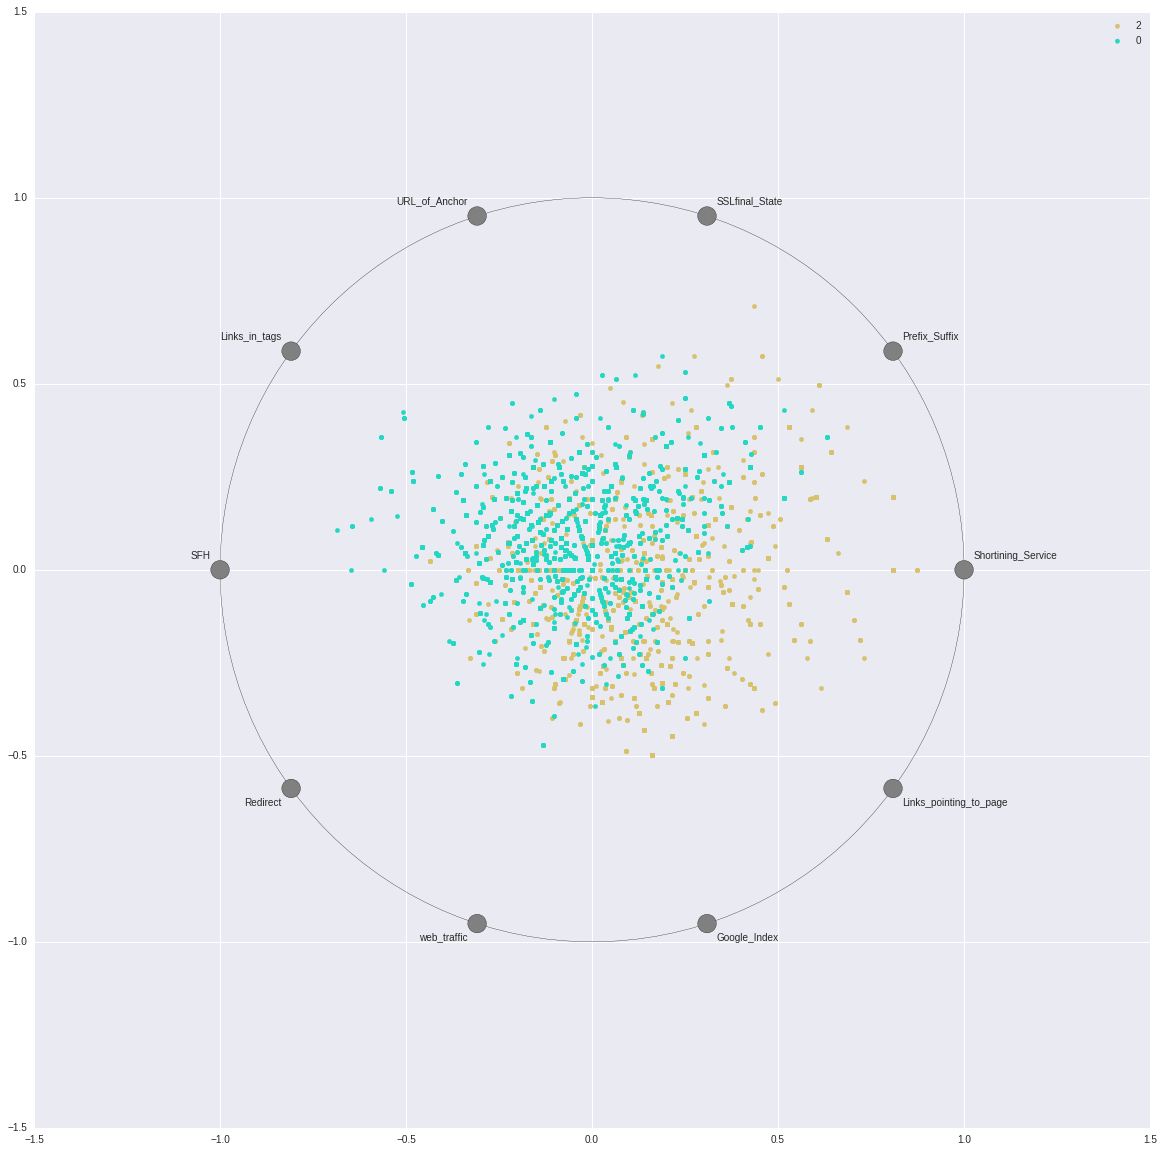

In [20]:
mod_features = df[['Shortining_Service', 'Prefix_Suffix', 'SSLfinal_State', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Redirect', 'web_traffic', 'Google_Index', 'Links_pointing_to_page', 'Result']]
plt.figure(figsize=(20,20))
radviz(mod_features, 'Result')
plt.show()

# Data Loading and Management

Next I organized the data to be received by SciKit-Learn as a Bunch object. 

First I created a JSON file with the feature and target labels. Since the data in the df dataframe, and associated .txt file, was int64 datatype, this was not JSON serializable. Since this data was generated off the same .csv as the data in df2 with the string values, I used df2 to form the meta file. 

In [21]:
g = df.columns.to_series().groupby(df.dtypes).groups
print (g)

{dtype('int64'): ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']}


In [22]:
import json 

meta = {
    'target_names': list(df2.Result.unique()),
    'feature_names': list(df2.columns),
    'categorical_features': {
        column: list(df2[column].unique())
        for column in df2.columns
        if df2[column].dtype == 'object'
    },
}

with open('meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

Having created the meta.json file, as well as a readme file which I created seperately from this notebook, I read this data into a 'bunch' object, along with the numerically encoded .txt file storing the feature and target data.

In [23]:
def load_data(root=os.getcwd()):
    # Construct the `Bunch` for the Phishing dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'Training_Dataset1.txt'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']
        
    #Alternative method for loading in target and featur labels.
    #target_names  = df.columns[-1]
    #feature_names = list(df.columns[0:-1])

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.genfromtxt(filenames['data'], delimiter=',')
        
    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print (dataset.data.shape)
print (dataset.target.shape)

(11055, 30)
(11055,)


I doubled checked that the data looked as expected.

In [24]:
print (dataset.data)
print (dataset.target)
print (dataset.target_names)
print (dataset.feature_names)

[[ 2.  1.  0. ...,  0.  1.  2.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 [ 0.  2.  0. ...,  0.  2.  2.]
 ..., 
 [ 0.  0.  0. ...,  0.  2.  0.]
 [ 2.  0.  0. ...,  0.  1.  0.]
 [ 2.  0.  0. ...,  2.  1.  2.]]
[ 2.  2.  2. ...,  2.  2.  2.]
['phishing', 'legitimate']
['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']


# Encoding and Inputation

Since the data I read into the bunch object was already numerically encoded, no additional transformation was necesary at this step. Though had I been using categorical data labled with string-values, for example, these would need to be re-encoded as numeric values. 

Additionally, if any of the features were missing data, I would need to implement a strategy to either drop the instance or input the missing data. Fortunately the dataset did not have any missing values. 

# Fitting and Evaluating Estimators

With the data loaded and prepared for fitting by the machine learning models, I used a function to assess the effectiveness of several different models. The function accepts the bunch object with the data, a selected model, and a string value to label the model as arguments. 

The function implements k-fold cross-validation, randomly partisioning the data into k equal sized subsets, in this case k = 12 subsets, retaining one set as validation set and the remaining sets as training data. 
It creates an estimator object and uses the model type designated in the argument to fit a model to the data. It then generates precision, recall, accuracy, and F1 scores for the fitted model. Scores are displayed upon execution of the function, the model itself is pickled, i.e. the python object is stored on disk.

In [25]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [26]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted,pos_label=2))
        scores['recall'].append(metrics.recall_score(expected, predicted,pos_label=2))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted,pos_label=2))

    # Report
    print ("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print ("Validation scores are as follows:\n")
    print (pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print ("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

I selected three different classifier models to fit a model to the data. The models I selected were:

Random Forest, which is an ensemble machine learning method that generates a collection of decision trees.
Naive Bayes, which uses bayes therom, but assumes no feature values are independent. 
Logistic Regression, a non-linear regression method used to classify a binary dependent variable.

Random Forest

In [27]:
fit_and_evaluate(dataset, RandomForestClassifier, "Phishing Random Forest Classifier")

Build and Validation of Phishing Random Forest Classifier took 0.966 seconds
Validation scores are as follows:

accuracy     0.970331
f1           0.966188
precision    0.974407
recall       0.958233
dtype: float64

Fitted model written to:
/home/merlinuser/Desktop/Make-up Assignment/phishing-random-forest-classifier.pickle


Naive Bayes

In [28]:
fit_and_evaluate(dataset, GaussianNB, "Phishing Naive Bayes Classifier")

Build and Validation of Phishing Naive Bayes Classifier took 0.192 seconds
Validation scores are as follows:

accuracy     0.576211
f1           0.676385
precision    0.511137
recall       1.000000
dtype: float64

Fitted model written to:
/home/merlinuser/Desktop/Make-up Assignment/phishing-naive-bayes-classifier.pickle


Logistic Regression

In [29]:
fit_and_evaluate(dataset, LogisticRegression, "Phishing Logistic Regression Classifier")

Build and Validation of Phishing Logistic Regression Classifier took 1.402 seconds
Validation scores are as follows:

accuracy     0.847580
f1           0.824192
precision    0.840813
recall       0.808410
dtype: float64

Fitted model written to:
/home/merlinuser/Desktop/Make-up Assignment/phishing-logistic-regression-classifier.pickle


# Operationalize the Model

The Random Forest model performed the best, as indicated by acheving the highest scores in both accuracy and precision (and F1, the aggregation of the two), and only trailing Naive Bayes in recall.

To operationalize this model, I used a function which retreives the fitted model stored on disk, then accepts and evaluates new input data provided by a user. The fitted model accepts numerically encoded inputs, and returns numerically encoded outputs, so string value inputs provided by the user are encoded as they are received, and nuerical outputs of the model (0 and 2), are presented as the expected string values, i.e. 0 = 'legitimate' and !=0 = 'phishing'. 

In [34]:
def load_model(path='phishing-random-forest-classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=meta):
    user_data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            print ("Choose one of the following: {}".format(valid))
            val = " " + input("enter {} >".format(column))
            if val == 'phishing':
                val = 2
                user_data[column] = val
            elif val == 'suspicious':
                val = 1
                user_data[column] = val
            else:
                val = 0
                user_data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([user_data]))
    yhat1 = yhat
    if 0 in yhat1:
        print ('\nThe predicted status of this URL is: Legitimate')
    else:
        print ('\nThe predicted status of this URL is: Phishing')
    
# Execute the interface 
model = load_model()
predict(model)

Choose one of the following: ['phishing', 'legitimate']
enter having_IP_Address >'legitimate'
Choose one of the following: ['suspicious', 'phishing', 'legitimate']
enter URL_Length >'legitimate'
Choose one of the following: ['legitimate', 'phishing']
enter Shortining_Service >'legitimate'
Choose one of the following: ['legitimate', 'phishing']
enter having_At_Symbol >'legitimate'
Choose one of the following: ['phishing', 'legitimate']
enter double_slash_redirecting >'legitimate'
Choose one of the following: ['phishing', 'legitimate']
enter Prefix_Suffix >'legitimate'
Choose one of the following: ['legitimate', 'phishing', 'suspicious']
enter having_Sub_Domain >'legitimate'
Choose one of the following: ['legitimate', 'suspicious', 'phishing']
enter SSLfinal_State >'legitimate'
Choose one of the following: ['phishing', 'legitimate']
enter Domain_registeration_length >'legitimate'
Choose one of the following: ['legitimate', 'phishing']
enter Favicon >'legitimate'
Choose one of the followi